# Imports

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By #ne znam zasto import selenium ne pokriva ovo
from selenium.common.exceptions import NoSuchElementException 
import re, nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import WordNetLemmatizer
import seaborn as sns  
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence

# Scraping

In [40]:
driver = webdriver.Chrome()
driver.implicitly_wait(20) 
driver.get("https://myanimelist.net/topanime.php?limit=50")
driver.maximize_window()

f = open("reviews.csv", "a", encoding="utf-8")
#f.write("id;name;score;demographic;genres;themes;username;rating;review\n")

animeListing_container = driver.find_element(By.XPATH, "/html/body/div[1]/div[2]/div[3]/div[2]/div[4]")
animeListing_elements = driver.find_elements(By.CLASS_NAME, "anime_ranking_h3")

id = 1607 #changeable - zadnji id u reviews
i = 0
for i in range(len(animeListing_elements) - 36): #changeable - zadnji zapisan anime
    animeListing_container = driver.find_element(By.XPATH, "/html/body/div[1]/div[2]/div[3]/div[2]/div[4]")
    animeListing_elements = driver.find_elements(By.CLASS_NAME, "anime_ranking_h3")
    del animeListing_elements[0:36] #changeable - zadnji zapisan anime
    
    animeListing_elements[i].click()
    name = driver.find_element(By.XPATH, "/html/body/div[1]/div[2]/div[3]/div[1]/div/div[1]/div/h1/strong").text
    name = re.sub(r";", ",", name)
    score = driver.find_element(By.XPATH, "/html/body/div[1]/div[2]/div[3]/div[2]/table/tbody/tr/td[2]/div[1]/table/tbody/tr[1]/td/div[1]/div[1]/div[1]/div[1]/div[1]/div").text
    
    try:
        genre_div = driver.find_element(By.XPATH, "//*[contains(text(), 'Genres:')]//ancestor::div[@class='spaceit_pad']")
        genre_elements = genre_div.find_elements(By.TAG_NAME, 'a')
        genres = [genre.text for genre in genre_elements]
    except NoSuchElementException:
        genres = []
    
    try:
        theme_div = driver.find_element(By.XPATH, "//*[contains(text(), 'Themes:')]//ancestor::div[@class='spaceit_pad']")
        theme_elements = theme_div.find_elements(By.TAG_NAME, 'a')
        themes = [theme.text for theme in theme_elements]
    except NoSuchElementException:
        themes = []
    
    try:
        demographic_div = driver.find_element(By.XPATH, "//*[contains(text(), 'Demographic:')]//ancestor::div[@class='spaceit_pad']")
        demographic_element = demographic_div.find_element(By.TAG_NAME, 'a')
        demographic = demographic_element.text
    except NoSuchElementException:
        demographic = ""
    
    driver.find_element(By.LINK_TEXT, 'Reviews').click()
    driver.find_element(By.XPATH, "/html/body/div[1]/div[2]/div[3]/div[2]/table/tbody/tr/td[2]/div[1]/div[5]/div[2]/span[4]").click()
    driver.find_element(By.CLASS_NAME, 'btn-show-filter').click()
    driver.find_element(By.XPATH, "//li[@data-id='3']").click()
    driver.find_element(By.CLASS_NAME, 'btn-show-filter').click()
    readMore_elements = driver.find_elements(By.CLASS_NAME, "js-readmore")
    for element in readMore_elements:
        element.click()
    review_elements = driver.find_elements(By.CLASS_NAME ,"review-element")
    for element in review_elements:
        username = element.find_element(By.CLASS_NAME, "username").text
        #print(username)
        review = element.find_element(By.CLASS_NAME, "text").text
        review = re.sub(r"\s+", " ", review)
        review = re.sub(r";", ",", review)
        #print(review)
        rating = element.find_element(By.CLASS_NAME, "rating").text[19:]
        if int(rating) > 5:
            continue
        #print(rating[19:])
        id += 1
        f.write(str(id) + ";" + name + ";" + score + ";" + demographic + ";" + str(genres) + ";" + str(themes) + ";" + username + ";" + rating + ";" + review + "\n")
        print(str(id) + " | " + name + " | " + score + " | " + demographic + " | " + str(genres) + " | " + str(themes) + " | " + username + " | " + rating + " | " + "REVIEW_TEXT")
        
    driver.get("https://myanimelist.net/topanime.php?limit=50")
    i += 1

f.close()
driver.quit()


1608 | "Oshi no Ko" 2nd Season | 8.62 | Seinen | [] | ['Reincarnation', 'Showbiz'] | aroruaa | 1 | REVIEW_TEXT
1609 | "Oshi no Ko" 2nd Season | 8.62 | Seinen | [] | ['Reincarnation', 'Showbiz'] | Blehnanas | 1 | REVIEW_TEXT
1610 | "Oshi no Ko" 2nd Season | 8.62 | Seinen | [] | ['Reincarnation', 'Showbiz'] | Shurikun_ | 3 | REVIEW_TEXT
1611 | "Oshi no Ko" 2nd Season | 8.62 | Seinen | [] | ['Reincarnation', 'Showbiz'] | Tkit | 4 | REVIEW_TEXT
1612 | "Oshi no Ko" 2nd Season | 8.62 | Seinen | [] | ['Reincarnation', 'Showbiz'] | PepperPwdr | 4 | REVIEW_TEXT
1613 | "Oshi no Ko" 2nd Season | 8.62 | Seinen | [] | ['Reincarnation', 'Showbiz'] | Ellenya | 3 | REVIEW_TEXT
1614 | Death Note | 8.62 | Shounen | ['Supernatural', 'Suspense'] | [] | Polyphemus | 4 | REVIEW_TEXT
1615 | Death Note | 8.62 | Shounen | ['Supernatural', 'Suspense'] | [] | NegativeFeelings | 4 | REVIEW_TEXT
1616 | Death Note | 8.62 | Shounen | ['Supernatural', 'Suspense'] | [] | abeldi | 2 | REVIEW_TEXT
1617 | Death Note | 8.

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/div[1]/div[2]/div[3]/div[1]/div/div[1]/div/h1/strong"}
  (Session info: chrome=131.0.6778.205); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7E54FFB05+28789]
	(No symbol) [0x00007FF7E54686E0]
	(No symbol) [0x00007FF7E530592A]
	(No symbol) [0x00007FF7E535930E]
	(No symbol) [0x00007FF7E53595FC]
	(No symbol) [0x00007FF7E53A28A7]
	(No symbol) [0x00007FF7E537F47F]
	(No symbol) [0x00007FF7E539F654]
	(No symbol) [0x00007FF7E537F1E3]
	(No symbol) [0x00007FF7E534A938]
	(No symbol) [0x00007FF7E534BAA1]
	GetHandleVerifier [0x00007FF7E583933D+3410093]
	GetHandleVerifier [0x00007FF7E584E7DD+3497293]
	GetHandleVerifier [0x00007FF7E5842A73+3448803]
	GetHandleVerifier [0x00007FF7E55C7BBB+848171]
	(No symbol) [0x00007FF7E5473C3F]
	(No symbol) [0x00007FF7E546F6E4]
	(No symbol) [0x00007FF7E546F87D]
	(No symbol) [0x00007FF7E545ED49]
	BaseThreadInitThunk [0x00007FFC205D259D+29]
	RtlUserThreadStart [0x00007FFC2212AF38+40]


In [2]:
pd.reset_option('display.max_colwidth')

df = pd.read_csv(r"reviews.csv", sep=';')
df.head()

,id,name,score,demographic,genres,themes,username,rating,review
0,0,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],Czekaj,10,"With lives so short, why do we even bother? To..."
1,1,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],chekkit,10,I feel so catered to. It feels like an eternit...
2,2,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],Trikkiez,4,Style- Frieren doesn't have its own unique sty...
3,3,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],ShabbaRico,5,"TL,DR: 5/10, I don't recommend this for anyone..."
4,4,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],TheRealist68,9,"Through 3 episodes, Frieren appears to be a un..."


# User Sentiment

In [3]:
def preprocess(text):
    text = re.sub(r"[^a-zA-Z\.\?!]", " ", text)
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [token for token in tokens if token not in stopwords.words("english")] #potencijanlo bespotrebno
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = " ".join(lemmatized_tokens)
    return processed_text

def get_sentiment(rating):
    if 1 <= rating <= 5:
        return "0"
    else:
        return "1"

In [4]:
tqdm.pandas()
df["review"] = df["review"].progress_apply(preprocess)
df["sentiment"] = df["rating"].progress_apply(get_sentiment)
df.head()

100%|██████████████████████████████████████████████████████████████████████████| 1738/1738 [00:00<00:00, 867614.90it/s]


,id,name,score,demographic,genres,themes,username,rating,review,sentiment
0,0,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],Czekaj,10,life short even bother ? someone life thousand...,1
1,1,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],chekkit,10,feel catered . feel like eternity since given ...,1
2,2,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],Trikkiez,4,style frieren unique style way . feel like eve...,0
3,3,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],ShabbaRico,5,tl dr recommend anyone standard enjoys fantasy...,0
4,4,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],TheRealist68,9,episode frieren appears unique masterpiece sto...,1


In [11]:
removed_count = 0
for index, row in df.iterrows():
    if row['sentiment'] == "0":
        df = df.drop(index)  
        removed_count += 1
        if removed_count == 210: 
            break


sentiment
1    762
0    762
Name: count, dtype: int64

In [42]:
df.to_csv("preprocessed_reviews.csv", sep=";", index=False)

# Graphs

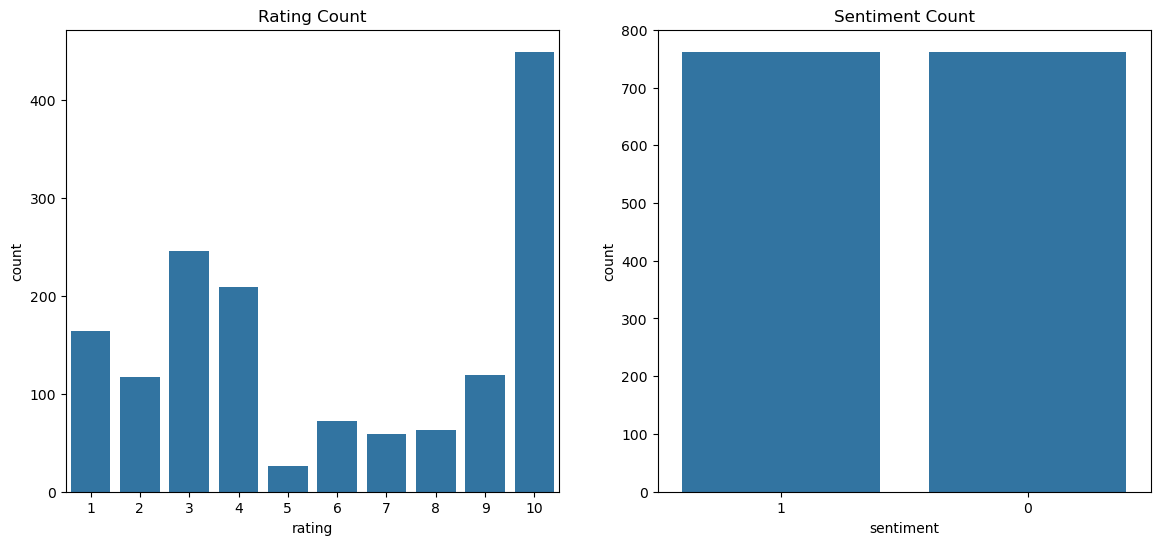

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x='rating', data=df, ax=axes[0])
axes[0].set_title("Rating Count")

sns.countplot(x='sentiment', data=df, ax=axes[1])
axes[1].set_title("Sentiment Count")

plt.show()


100%|███████████████████████████████████████████████████████████████████████████████| 762/762 [00:03<00:00, 226.08it/s]


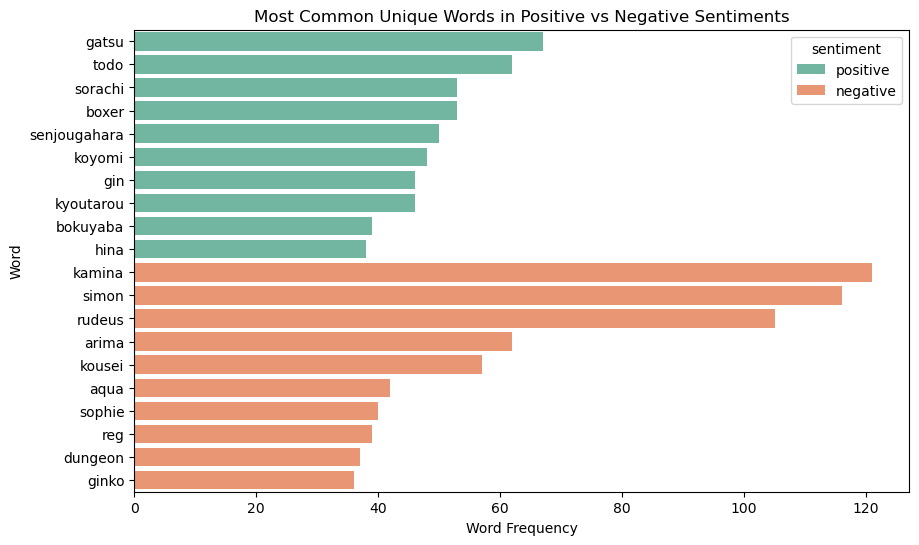

In [64]:
positive_df = df[df['sentiment'] == "1"]
negative_df = df[df['sentiment'] == "0"]

positive_tokens = positive_df['review'].progress_apply(nltk.word_tokenize).explode()
negative_tokens = negative_df['review'].progress_apply(nltk.word_tokenize).explode()

# nadje common token izmedju pos i neg tokens
common_tokens = set(positive_tokens) & set(negative_tokens)

# remove common tokens from both dfs
positive_tokens_unique = positive_tokens[~positive_tokens.isin(common_tokens)]
negative_tokens_unique = negative_tokens[~negative_tokens.isin(common_tokens)]

positive_freq_dist_unique = nltk.FreqDist(positive_tokens_unique)
negative_freq_dist_unique = nltk.FreqDist(negative_tokens_unique)

positive_common_words = positive_freq_dist_unique.most_common(10)
negative_common_words = negative_freq_dist_unique.most_common(10)

positive_df_plot = pd.DataFrame({'word': positive_words, 'count': positive_counts, 'sentiment': 'positive'})
negative_df_plot = pd.DataFrame({'word': negative_words, 'count': negative_counts, 'sentiment': 'negative'})

# spoji oba plota
plot_df = pd.concat([positive_df_plot, negative_df_plot])

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', hue='sentiment', data=plot_df, palette="Set2")

plt.title('Most Common Unique Words in Positive vs Negative Sentiments')
plt.xlabel('Word Frequency')
plt.ylabel('Word')

plt.show()

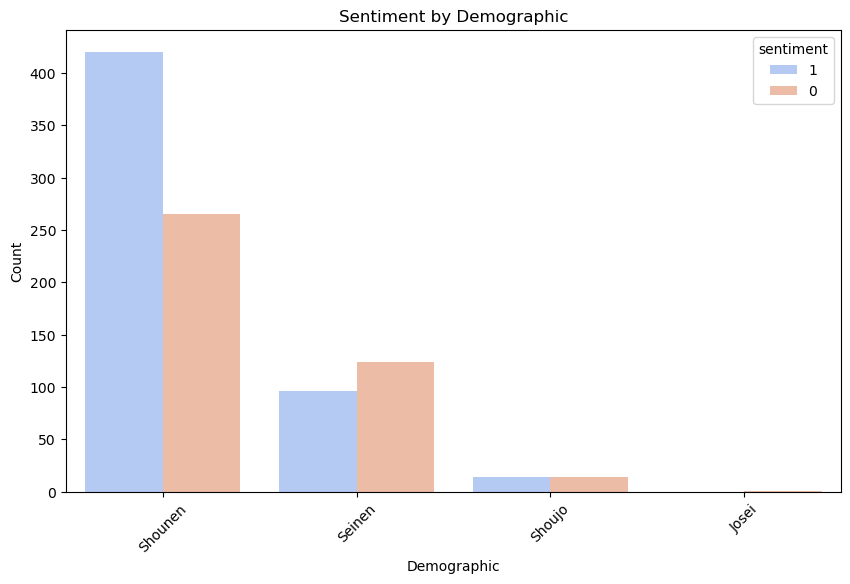

In [60]:
plt.figure(figsize=(10, 6))
sns.countplot(x='demographic', hue='sentiment', data=df, palette='coolwarm')
plt.title('Sentiment by Demographic')
plt.xlabel('Demographic')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Training Our Comparison

In [13]:
X = df["review"].values
Y = df["sentiment"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 2)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

model = LogisticRegression(max_iter = 1000)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [15]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print("Accuracy score on the training data: ", training_data_accuracy)

X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)
print("Accuracy score on the test data: ", test_data_accuracy)

Accuracy score on the training data:  0.9662288930581614
Accuracy score on the test data:  0.9017467248908297


# Vader Comparison

In [16]:
vader = SentimentIntensityAnalyzer()

def get_vader_sentiment(review):
    score = vader.polarity_scores(review)
    if score['compound'] >= 0.0:
        return '1'
    else:
        return '0'

vader_predictions = [get_vader_sentiment(review) for review in df["review"][int(df.shape[0] * 0.7):]] #X_test

vader_accuracy = accuracy_score(Y_test, vader_predictions)
print("Accuracy score using our model on the test data: ", test_data_accuracy)
print("Accuracy score using VADER model on the test data: ", vader_accuracy)

Accuracy score using our model on the test data:  0.9017467248908297
Accuracy score using VADER model on the test data:  0.48253275109170307


# TextBlob Comparison

In [17]:
def get_textblob_sentiment(review):
    sentiment = TextBlob(review).sentiment.polarity
    if sentiment >= 0.0:
        return "1"
    else:
        return "0"

textblob_predictions = [get_textblob_sentiment(review) for review in df["review"][int(df.shape[0] * 0.7):]]

textblob_accuracy = accuracy_score(Y_test, textblob_predictions)
print("Accuracy score using our model on the test data: ", test_data_accuracy)
print("Accuracy score using TextBlob on the test data: ", textblob_accuracy)

Accuracy score using our model on the test data:  0.9017467248908297
Accuracy score using TextBlob on the test data:  0.4978165938864629


# Flair Comparison

In [18]:
flair_model = TextClassifier.load('sentiment')

def get_flair_sentiment(review):
    sentence = Sentence(review)
    flair_model.predict(sentence)
    sentiment = sentence.labels[0].value
    if sentiment == "POSITIVE":
        return "1"
    else:
        return "0"
        
flair_predictions = [get_flair_sentiment(review) for review in df["review"][int(df.shape[0] * 0.7):]]

flair_accuracy = accuracy_score(Y_test, flair_predictions)
print("Accuracy score using our model on the test data: ", test_data_accuracy)
print("Accuracy score using Flair on the test data: ", flair_accuracy)

Accuracy score using our model on the test data:  0.9017467248908297
Accuracy score using Flair on the test data:  0.4978165938864629


# Our Accuracy Testing

In [26]:
# Test with different inputs
anime_reviews = [
    """I must say, watching this anime was an emotional rollercoaster that I never expected to experience. 
    From the very first episode, the character development was nothing short of extraordinary. The protagonist's journey from being a timid, uncertain individual to a confident and inspiring hero was both believable and moving. 
    What truly set this series apart, however, was its ability to tackle profound themes like loss, redemption, and the importance of human connections. 
    The animation quality was absolutely stunning, with vivid colors, intricate details, and action sequences that left me on the edge of my seat. 
    The soundtrack deserves a special mention too – every note seemed to perfectly complement the mood, whether it was an intense battle or a tender, heartfelt moment. 
    But what really moved me were the relationships. The dynamics between the characters felt genuine and complex, filled with warmth and conflict, much like real-life friendships and rivalries. 
    By the time I reached the finale, I was in tears, completely invested in the world and the people within it. This anime is a masterpiece, and it will remain etched in my heart forever.""",

    """Honestly, I cannot fathom how this anime managed to garner such a devoted fanbase. From start to finish, the plot was riddled with cliches and inconsistencies that made it hard to take seriously. 
    The protagonist was unbearably one-dimensional, spouting the same recycled motivational lines episode after episode without any meaningful growth or development. 
    The side characters, instead of adding depth, were little more than walking stereotypes with predictable story arcs. 
    The animation, while occasionally passable, often felt lazy and uninspired, with choppy action sequences and static backgrounds that broke any sense of immersion. 
    And don't get me started on the pacing – entire episodes dragged on with pointless filler, while key story moments were rushed through with no room for emotional impact. 
    The dialogue was cringe-worthy at best, and the forced melodrama felt manipulative rather than genuine. 
    By the time I got to the end, I couldn't care less about what happened to the characters or the story. 
    It's safe to say that this was a colossal waste of time and one of the most disappointing anime experiences I've ever had.""",

    """This anime exceeded every expectation I had going in, and I can confidently say it is a modern classic. 
    The narrative weaves together a perfect blend of action, mystery, and emotional drama, creating a story that is as thrilling as it is heart-wrenching. 
    The world-building was unparalleled – every location felt alive, from the bustling streets of the city to the serene countryside, each with its own distinct atmosphere. 
    The characters were some of the most well-written I’ve ever seen, with complex motivations and realistic flaws that made them feel like real people. 
    What I found particularly compelling was how the anime handled its darker themes, addressing issues like societal inequality, existential despair, and the fragility of hope with such nuance and sensitivity. 
    The voice acting was another standout aspect; every line was delivered with such raw emotion that it felt like the characters were speaking directly to my soul. 
    And let's not forget the plot twists – every one of them was masterfully executed, leaving me shocked and eagerly anticipating what would happen next. 
    This anime is not just entertainment; it’s an experience, one that will stay with me for years to come.""",

    """I really wanted to like this anime, but it just kept letting me down at every turn. 
    The story had potential – the premise was intriguing, and I thought it could go in so many exciting directions, but instead, it just meandered aimlessly. 
    The main character was insufferable, constantly making irrational decisions that made no sense given their supposed intelligence and skills. 
    The antagonist was equally disappointing, with motivations that were so laughably shallow it was hard to take them seriously as a threat. 
    The animation quality fluctuated wildly, with some scenes looking downright amateurish, especially during pivotal moments where the quality mattered most. 
    The soundtrack was generic and forgettable, doing nothing to elevate the scenes it accompanied. 
    What really irked me was the lack of payoff – the show kept building up mysteries and conflicts, only to resolve them in ways that felt cheap and unsatisfying. 
    By the time I finished the series, I felt more frustrated than anything, wondering why I had bothered sticking with it for so long. 
    I wouldn’t recommend this anime to anyone unless you enjoy being disappointed.""",

    """This anime is truly a gem and deserves all the praise it has received. 
    From the moment it started, I was completely captivated by the intricate storytelling and the richly developed characters. 
    Each episode felt like a carefully crafted piece of art, combining stunning animation, a hauntingly beautiful soundtrack, and a plot that kept me hooked from beginning to end. 
    The way the story unfolded was nothing short of genius, with layers of symbolism and foreshadowing that only became apparent on a second watch. 
    The themes explored were deep and thought-provoking, challenging me to reflect on my own beliefs and emotions. 
    I especially appreciated how the anime didn’t shy away from portraying the harsh realities of life, making the moments of hope and triumph all the more impactful. 
    The voice acting was phenomenal, bringing the characters to life in a way that felt authentic and deeply moving. 
    By the time the final credits rolled, I was left in awe, grateful for the journey this anime had taken me on. It’s a masterpiece that I will treasure forever.""",


    """I was genuinely surprised by how much I ended up enjoying this anime. At first, I thought the premise was a bit silly and clichéd, but as the story progressed, I was drawn into its world. 
    The character interactions were incredibly charming, and the humor was perfectly timed, making me laugh out loud more times than I could count. 
    The story struck a wonderful balance between lighthearted moments and serious, emotional arcs, making it a well-rounded viewing experience. 
    I also appreciated the underlying message about self-acceptance and finding strength in unexpected places. 
    While the animation wasn't groundbreaking, it had a certain charm that matched the tone of the story perfectly. 
    By the end, I found myself wishing there was more to watch – it’s one of those rare shows that leaves you feeling warm and hopeful.""",

    """This anime was a complete disaster from start to finish. I don’t understand how anyone could recommend this to others. 
    The plot was so convoluted and nonsensical that I found myself constantly pausing to try and make sense of what was happening – spoiler alert: it never made sense. 
    The characters were bland and forgettable, with zero chemistry between them. Even the main character, who is supposed to carry the story, felt lifeless and uninspired. 
    The dialogue was cringeworthy, filled with forced attempts at humor that fell flat every single time. 
    To top it off, the animation quality was abysmal. I’ve seen better visuals in shows from decades ago. 
    By the time the series ended, I felt nothing but relief that I didn’t have to endure another minute of this mess. If you value your time, steer clear of this anime at all costs.""",

    """This anime was a mixed bag for me. On one hand, I really enjoyed the unique concept and the creativity that went into the world-building. 
    The visuals were striking in some places, especially during the action sequences, which were a real highlight. 
    However, the story felt somewhat inconsistent. While some episodes were incredibly engaging and emotional, others dragged on without adding much to the overall plot. 
    The main character had some compelling moments, but their development felt uneven, leaving me wishing for a bit more depth and growth. 
    The supporting cast had potential, but many of their storylines felt underutilized, which was disappointing given the time spent setting them up. 
    Overall, I wouldn’t say it’s a must-watch, but it does have its moments and could be worth a try if you’re into the genre.""",

    """This anime left me feeling very conflicted. While it had some undeniably strong moments, particularly in its emotional climaxes, the rest of the series felt disjointed and lacking in focus. 
    The animation quality was inconsistent, with some scenes looking gorgeous while others appeared rushed and unfinished. 
    The characters had interesting setups, but their arcs didn’t always feel satisfying, often falling into predictable tropes. 
    I also found the pacing to be uneven – the story would jump between slow, overly detailed episodes and rushed resolutions that left little room for meaningful impact. 
    The soundtrack was serviceable but not memorable, and the dialogue sometimes bordered on cheesy. 
    While I can see why some people might enjoy this show, I can’t say it fully worked for me. It’s not bad, but it’s not great either – just okay at best."""
]

#Correct Result: 1 0 1 0 1 1 0 1 0

for string in anime_reviews:
    transformed = vectorizer.transform([preprocess(string)])
    prediction = model.predict(transformed)
    print(f"Predicted Sentiment: {prediction[0]}\n")


Predicted Sentiment: 1

Predicted Sentiment: 0

Predicted Sentiment: 1

Predicted Sentiment: 0

Predicted Sentiment: 1

Predicted Sentiment: 1

Predicted Sentiment: 0

Predicted Sentiment: 0

Predicted Sentiment: 0

